# Warm up

In [1]:
!pip install git+https://github.com/joshivedant/bert_score --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.8 MB/s eta 0:00:00


In [2]:
!pip install sentencepiece --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.1 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/riteshpanjwani/pyiwn.git --quiet

  Preparing metadata (setup.py) ... done


In [4]:
!pip install indic-nlp-library --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 15.7 MB/s eta 0:00:00


In [5]:
import pandas as pd
from indicnlp.tokenize.indic_tokenize import trivial_tokenize, trivial_tokenize_indic
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import bert_score
from bert_score import score
import pickle
from itertools import chain, product
from typing import Callable, Iterable, List, Tuple
from nltk.corpus import WordNetCorpusReader, wordnet
from nltk.stem.api import StemmerI
from nltk.stem.porter import PorterStemmer
import pyiwn  #Hindi-wordnet
from nltk.metrics import edit_distance

# write list to binary file
def write_list(a_list, name):
    # store list in binary file so 'wb' mode
    with open(name, 'wb') as fp:
        pickle.dump(a_list, fp)
        # print('Done writing list into a binary file')

# Read list to memory
def read_list(name):
    # for reading also binary mode is important
    with open(name, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list


# Writing Code for METEOR metric

def _generate_enums(
    hypothesis: Iterable[str],
    reference: Iterable[str],
    preprocess: Callable[[str], str] = str.lower,
) -> Tuple[List[Tuple[int, str]], List[Tuple[int, str]]]:
    """
    Takes in pre-tokenized inputs for hypothesis and reference and returns
    enumerated word lists for each of them

    :param hypothesis: pre-tokenized hypothesis
    :param reference: pre-tokenized reference
    :preprocess: preprocessing method (default str.lower)
    :return: enumerated words list
    """
    if isinstance(hypothesis, str):
        raise TypeError(
            f'"hypothesis" expects pre-tokenized hypothesis (Iterable[str]): {hypothesis}'
        )

    if isinstance(reference, str):
        raise TypeError(
            f'"reference" expects pre-tokenized reference (Iterable[str]): {reference}'
        )

    enum_hypothesis_list = list(enumerate(map(preprocess, hypothesis)))
    enum_reference_list = list(enumerate(map(preprocess, reference)))
    return enum_hypothesis_list, enum_reference_list


def exact_match(
    hypothesis: Iterable[str], reference: Iterable[str]
) -> Tuple[List[Tuple[int, int]], List[Tuple[int, str]], List[Tuple[int, str]]]:
    """
    matches exact words in hypothesis and reference
    and returns a word mapping based on the enumerated
    word id between hypothesis and reference

    :param hypothesis: pre-tokenized hypothesis
    :param reference: pre-tokenized reference
    :return: enumerated matched tuples, enumerated unmatched hypothesis tuples,
             enumerated unmatched reference tuples
    """
    enum_hypothesis_list, enum_reference_list = _generate_enums(hypothesis, reference)
    return _match_enums(enum_hypothesis_list, enum_reference_list)


def _match_enums(
    enum_hypothesis_list: List[Tuple[int, str]],
    enum_reference_list: List[Tuple[int, str]],
) -> Tuple[List[Tuple[int, int]], List[Tuple[int, str]], List[Tuple[int, str]]]:
    """
    matches exact words in hypothesis and reference and returns
    a word mapping between enum_hypothesis_list and enum_reference_list
    based on the enumerated word id.

    :param enum_hypothesis_list: enumerated hypothesis list
    :param enum_reference_list: enumerated reference list
    :return: enumerated matched tuples, enumerated unmatched hypothesis tuples,
             enumerated unmatched reference tuples
    """
    word_match = []
    for i in range(len(enum_hypothesis_list))[::-1]:
        for j in range(len(enum_reference_list))[::-1]:
            if enum_hypothesis_list[i][1] == enum_reference_list[j][1]:
                word_match.append(
                    (enum_hypothesis_list[i][0], enum_reference_list[j][0])
                )
                enum_hypothesis_list.pop(i)
                enum_reference_list.pop(j)
                break
    return word_match, enum_hypothesis_list, enum_reference_list


def _enum_stem_match(
    enum_hypothesis_list: List[Tuple[int, str]],
    enum_reference_list: List[Tuple[int, str]],
    stemmer: StemmerI = PorterStemmer(),
) -> Tuple[List[Tuple[int, int]], List[Tuple[int, str]], List[Tuple[int, str]]]:
    """
    Stems each word and matches them in hypothesis and reference
    and returns a word mapping between enum_hypothesis_list and
    enum_reference_list based on the enumerated word id. The function also
    returns a enumerated list of unmatched words for hypothesis and reference.

    :param enum_hypothesis_list: enumerated hypothesis list
    :param enum_reference_list: enumerated reference list
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :return: enumerated matched tuples, enumerated unmatched hypothesis tuples,
             enumerated unmatched reference tuples
    """
    stemmed_enum_hypothesis_list = [
        (word_pair[0], stemmer.stem(word_pair[1])) for word_pair in enum_hypothesis_list
    ]

    stemmed_enum_reference_list = [
        (word_pair[0], stemmer.stem(word_pair[1])) for word_pair in enum_reference_list
    ]

    return _match_enums(stemmed_enum_hypothesis_list, stemmed_enum_reference_list)


def stem_match(
    hypothesis: Iterable[str],
    reference: Iterable[str],
    stemmer: StemmerI = PorterStemmer(),
) -> Tuple[List[Tuple[int, int]], List[Tuple[int, str]], List[Tuple[int, str]]]:
    """
    Stems each word and matches them in hypothesis and reference
    and returns a word mapping between hypothesis and reference

    :param hypothesis: pre-tokenized hypothesis
    :param reference: pre-tokenized reference
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :return: enumerated matched tuples, enumerated unmatched hypothesis tuples,
             enumerated unmatched reference tuples
    """
    enum_hypothesis_list, enum_reference_list = _generate_enums(hypothesis, reference)
    return _enum_stem_match(enum_hypothesis_list, enum_reference_list, stemmer=stemmer)


def _enum_wordnetsyn_match(
    enum_hypothesis_list: List[Tuple[int, str]],
    enum_reference_list: List[Tuple[int, str]],
    wordnet: WordNetCorpusReader = wordnet,
) -> Tuple[List[Tuple[int, int]], List[Tuple[int, str]], List[Tuple[int, str]]]:
    """
    Matches each word in reference to a word in hypothesis
    if any synonym of a hypothesis word is the exact match
    to the reference word.

    :param enum_hypothesis_list: enumerated hypothesis list
    :param enum_reference_list: enumerated reference list
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    """
    word_match = []
    for i in range(len(enum_hypothesis_list))[::-1]:
        hypothesis_syns = set(
            chain.from_iterable(
                (
                    lemma.name()
                    for lemma in synset.lemmas()
                    if lemma.name().find("_") < 0
                )
                for synset in wordnet.synsets(enum_hypothesis_list[i][1])
            )
        ).union({enum_hypothesis_list[i][1]})
        for j in range(len(enum_reference_list))[::-1]:
            if enum_reference_list[j][1] in hypothesis_syns:
                word_match.append(
                    (enum_hypothesis_list[i][0], enum_reference_list[j][0])
                )
                enum_hypothesis_list.pop(i)
                enum_reference_list.pop(j)
                break
    return word_match, enum_hypothesis_list, enum_reference_list


def wordnetsyn_match(
    hypothesis: Iterable[str],
    reference: Iterable[str],
    wordnet: WordNetCorpusReader = wordnet,
) -> Tuple[List[Tuple[int, int]], List[Tuple[int, str]], List[Tuple[int, str]]]:
    """
    Matches each word in reference to a word in hypothesis if any synonym
    of a hypothesis word is the exact match to the reference word.

    :param hypothesis: pre-tokenized hypothesis
    :param reference: pre-tokenized reference
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :return: list of mapped tuples
    """
    enum_hypothesis_list, enum_reference_list = _generate_enums(hypothesis, reference)
    return _enum_wordnetsyn_match(
        enum_hypothesis_list, enum_reference_list, wordnet=wordnet
    )


def _enum_align_words(
    enum_hypothesis_list: List[Tuple[int, str]],
    enum_reference_list: List[Tuple[int, str]],
    stemmer: StemmerI = PorterStemmer(),
    wordnet: WordNetCorpusReader = wordnet,
) -> Tuple[List[Tuple[int, int]], List[Tuple[int, str]], List[Tuple[int, str]]]:
    """
    Aligns/matches words in the hypothesis to reference by sequentially
    applying exact match, stemmed match and wordnet based synonym match.
    in case there are multiple matches the match which has the least number
    of crossing is chosen. Takes enumerated list as input instead of
    string input

    :param enum_hypothesis_list: enumerated hypothesis list
    :param enum_reference_list: enumerated reference list
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :return: sorted list of matched tuples, unmatched hypothesis list,
             unmatched reference list
    """
    exact_matches, enum_hypothesis_list, enum_reference_list = _match_enums(
        enum_hypothesis_list, enum_reference_list
    )

    stem_matches, enum_hypothesis_list, enum_reference_list = _enum_stem_match(
        enum_hypothesis_list, enum_reference_list, stemmer=stemmer
    )

    wns_matches, enum_hypothesis_list, enum_reference_list = _enum_wordnetsyn_match(
        enum_hypothesis_list, enum_reference_list, wordnet=wordnet
    )

    return (
        sorted(
            exact_matches + stem_matches + wns_matches, key=lambda wordpair: wordpair[0]
        ),
        enum_hypothesis_list,
        enum_reference_list,
    )


def align_words(
    hypothesis: Iterable[str],
    reference: Iterable[str],
    stemmer: StemmerI = PorterStemmer(),
    wordnet: WordNetCorpusReader = wordnet,
) -> Tuple[List[Tuple[int, int]], List[Tuple[int, str]], List[Tuple[int, str]]]:
    """
    Aligns/matches words in the hypothesis to reference by sequentially
    applying exact match, stemmed match and wordnet based synonym match.
    In case there are multiple matches the match which has the least number
    of crossing is chosen.

    :param hypothesis: pre-tokenized hypothesis
    :param reference: pre-tokenized reference
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :return: sorted list of matched tuples, unmatched hypothesis list, unmatched reference list
    """
    enum_hypothesis_list, enum_reference_list = _generate_enums(hypothesis, reference)
    return _enum_align_words(
        enum_hypothesis_list, enum_reference_list, stemmer=stemmer, wordnet=wordnet
    )


def _count_chunks(matches: List[Tuple[int, int]]) -> int:
    """
    Counts the fewest possible number of chunks such that matched unigrams
    of each chunk are adjacent to each other. This is used to calculate the
    fragmentation part of the metric.

    :param matches: list containing a mapping of matched words (output of align_words)
    :return: Number of chunks a sentence is divided into post alignment
    """
    i = 0
    chunks = 1
    while i < len(matches) - 1:
        if (matches[i + 1][0] == matches[i][0] + 1) and (
            matches[i + 1][1] == matches[i][1] + 1
        ):
            i += 1
            continue
        i += 1
        chunks += 1
    return chunks


def single_meteor_score(
    reference: Iterable[str],
    hypothesis: Iterable[str],
    preprocess: Callable[[str], str] = str.lower,
    stemmer: StemmerI = PorterStemmer(),
    wordnet: WordNetCorpusReader = wordnet,
    alpha: float = 0.9,
    beta: float = 3.0,
    gamma: float = 0.5,
) -> float:
    """
    Calculates METEOR score for single hypothesis and reference as per
    "Meteor: An Automatic Metric for MT Evaluation with HighLevels of
    Correlation with Human Judgments" by Alon Lavie and Abhaya Agarwal,
    in Proceedings of ACL.
    https://www.cs.cmu.edu/~alavie/METEOR/pdf/Lavie-Agarwal-2007-METEOR.pdf


    >>> hypothesis1 = ['It', 'is', 'a', 'guide', 'to', 'action', 'which', 'ensures', 'that', 'the', 'military', 'always', 'obeys', 'the', 'commands', 'of', 'the', 'party']

    >>> reference1 = ['It', 'is', 'a', 'guide', 'to', 'action', 'that', 'ensures', 'that', 'the', 'military', 'will', 'forever', 'heed', 'Party', 'commands']


    >>> round(single_meteor_score(reference1, hypothesis1),4)
    0.6944

        If there is no words match during the alignment the method returns the
        score as 0. We can safely  return a zero instead of raising a
        division by zero error as no match usually implies a bad translation.

    >>> round(single_meteor_score(['this', 'is', 'a', 'cat'], ['non', 'matching', 'hypothesis']),4)
    0.0

    :param reference: pre-tokenized reference
    :param hypothesis: pre-tokenized hypothesis
    :param preprocess: preprocessing function (default str.lower)
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :param alpha: parameter for controlling relative weights of precision and recall.
    :param beta: parameter for controlling shape of penalty as a
                 function of as a function of fragmentation.
    :param gamma: relative weight assigned to fragmentation penalty.
    :return: The sentence-level METEOR score.
    """
    enum_hypothesis, enum_reference = _generate_enums(
        hypothesis, reference, preprocess=preprocess
    )
    translation_length = len(enum_hypothesis)
    reference_length = len(enum_reference)
    matches, _, _ = _enum_align_words(
        enum_hypothesis, enum_reference, stemmer=stemmer, wordnet=wordnet
    )
    matches_count = len(matches)
    try:
        precision = float(matches_count) / translation_length
        recall = float(matches_count) / reference_length
        fmean = (precision * recall) / (alpha * precision + (1 - alpha) * recall)
        chunk_count = float(_count_chunks(matches))
        frag_frac = chunk_count / matches_count
    except ZeroDivisionError:
        return 0.0
    penalty = gamma * frag_frac**beta
    return (1 - penalty) * fmean


def meteor_score(
    references: Iterable[Iterable[str]],
    hypothesis: Iterable[str],
    preprocess: Callable[[str], str] = str.lower,
    stemmer: StemmerI = PorterStemmer(),
    wordnet: WordNetCorpusReader = wordnet,
    alpha: float = 0.9,
    beta: float = 3.0,
    gamma: float = 0.5,
) -> float:
    """
    Calculates METEOR score for hypothesis with multiple references as
    described in "Meteor: An Automatic Metric for MT Evaluation with
    HighLevels of Correlation with Human Judgments" by Alon Lavie and
    Abhaya Agarwal, in Proceedings of ACL.
    https://www.cs.cmu.edu/~alavie/METEOR/pdf/Lavie-Agarwal-2007-METEOR.pdf


    In case of multiple references the best score is chosen. This method
    iterates over single_meteor_score and picks the best pair among all
    the references for a given hypothesis

    >>> hypothesis1 = ['It', 'is', 'a', 'guide', 'to', 'action', 'which', 'ensures', 'that', 'the', 'military', 'always', 'obeys', 'the', 'commands', 'of', 'the', 'party']
    >>> hypothesis2 = ['It', 'is', 'to', 'insure', 'the', 'troops', 'forever', 'hearing', 'the', 'activity', 'guidebook', 'that', 'party', 'direct']

    >>> reference1 = ['It', 'is', 'a', 'guide', 'to', 'action', 'that', 'ensures', 'that', 'the', 'military', 'will', 'forever', 'heed', 'Party', 'commands']
    >>> reference2 = ['It', 'is', 'the', 'guiding', 'principle', 'which', 'guarantees', 'the', 'military', 'forces', 'always', 'being', 'under', 'the', 'command', 'of', 'the', 'Party']
    >>> reference3 = ['It', 'is', 'the', 'practical', 'guide', 'for', 'the', 'army', 'always', 'to', 'heed', 'the', 'directions', 'of', 'the', 'party']

    >>> round(meteor_score([reference1, reference2, reference3], hypothesis1),4)
    0.6944

        If there is no words match during the alignment the method returns the
        score as 0. We can safely  return a zero instead of raising a
        division by zero error as no match usually implies a bad translation.

    >>> round(meteor_score([['this', 'is', 'a', 'cat']], ['non', 'matching', 'hypothesis']),4)
    0.0

    :param references: pre-tokenized reference sentences
    :param hypothesis: a pre-tokenized hypothesis sentence
    :param preprocess: preprocessing function (default str.lower)
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :param alpha: parameter for controlling relative weights of precision and recall.
    :param beta: parameter for controlling shape of penalty as a function
                 of as a function of fragmentation.
    :param gamma: relative weight assigned to fragmentation penalty.
    :return: The sentence-level METEOR score.
    """
    return max(
        single_meteor_score(
            reference,
            hypothesis,
            preprocess=preprocess,
            stemmer=stemmer,
            wordnet=wordnet,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
        )
        for reference in references
    )


# Function for TER
def get_ter(ref, hyp):
    """
    This function calculates the Translation Error Rate (TER) given the reference (ref) and hypothesis (hyp) translations in Hindi.
    """
    # Tokenize the reference and hypothesis translations using the IndicTokenizer
    # tokenizer = IndicTokenizer('hi')
    ref_tokens = trivial_tokenize(ref)
    hyp_tokens = trivial_tokenize(hyp)

    # Compute the edit distance between the tokenized translations using the edit_distance function
    edit_dis = edit_distance(ref_tokens, hyp_tokens)

    # Compute the TER score as the edit distance divided by the length of the reference translation
    ter_score = edit_dis / len(ref_tokens)

    return ter_score

# TER scores can be greater than 1
def normalize_ter_scores(scores):
  res = [1-min(1, score) for score in scores]
  return res


# BLEU scores function 
def get_bleu(cand, ref):
    c_tokens = trivial_tokenize(cand.lower(),lang='hi')
    r_tokens = trivial_tokenize(ref.lower(),lang='hi')

    # considering 3-gram overlap
    weights=(1./3., 1./3., 1./3.)
    bl_sc = sentence_bleu([r_tokens], c_tokens, weights=weights)
    return bl_sc

# Get Function for Meteor Score
def get_meteor(ref, cand):
    references = [ref.split(" ")]
    predictions = cand.split(" ")
    m_score = meteor_score(references = references, hypothesis=predictions, wordnet = pyiwn.IndoWordNet())
    return m_score

# function to get BERT Score
# list of candidate and reference
def get_bert(cand, ref):
    bert_score = score(cand, ref, lang='hi')
    return bert_score


[██████████████████████████████████████████████████]


# Preparation of data

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [7]:
data = read_list('ref_cand_pairs_en-hi_wmt-14')

data = np.array(data)
n = len(data)

X = data[:,:2]

Y = data[:,2].astype('float')

In [8]:
X.shape

(8490, 2)

In [9]:
X[10:15]

array([['हालांकि इस वर्ष ऐसी वस्तुओं पर महंगाई का ग्रहण लगा रहा, लेकिन लोगों ने फिर भी शुभ मुहुर्त पर खरीददारी करने में कंजूसी नहीं दिखाई।',
        'हालांकि खड़ा था, फिर भी ये लोग नहीं दूँगा- है जबकि क्रय इस शुभ अवसर पर है ।'],
       ['हालांकि इस वर्ष ऐसी वस्तुओं पर महंगाई का ग्रहण लगा रहा, लेकिन लोगों ने फिर भी शुभ मुहुर्त पर खरीददारी करने में कंजूसी नहीं दिखाई।',
        'मुद्रास्फीति इन मदों त्रस्त था, लोग पैसा बन्द रखो इस शुभ अवसर पर खरीदते समय हो ही नहीं किया.'],
       ['हालांकि इस वर्ष ऐसी वस्तुओं पर महंगाई का ग्रहण लगा रहा, लेकिन लोगों ने फिर भी शुभ मुहुर्त पर खरीददारी करने में कंजूसी नहीं दिखाई।',
        'हालांकि स़्फीती तंग था, लोग इन मदों नहीं लग रहा था जबकि सब - पिनचिंग इस शुभ अवसर पर ।'],
       ['हालांकि इस वर्ष ऐसी वस्तुओं पर महंगाई का ग्रहण लगा रहा, लेकिन लोगों ने फिर भी शुभ मुहुर्त पर खरीददारी करने में कंजूसी नहीं दिखाई।',
        'हालांकि इन वस्तुओं को दुबारा किया था, लोगों को नहीं लग रहा था जबकि इस शुभ अवसर पर सकते हैं ।'],
       ['हालांकि इस वर्ष ऐसी वस्तुओं पर म

In [ ]:
X.dtype

dtype('<U226')

In [10]:
Y[11]

5.0

In [11]:
y = np.zeros((n, 5))
for i in range(n):
  y[i][int(Y[i])-1] = 1.0

In [12]:
y

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [13]:
X[:, 1]

array(['लोगों की मीटिंग में आभूषणों की दुकानों में शिमला ।',
       'लोग शिमला में आभूषण की दुकानों पर भीड़.',
       'आभूषणों की दुकानों में लोगों की भीड शिमला ।', ...,
       'बंद करो और नाचना रणनीति नागरिक अधिकारों की वकालत की एक संख्या से आलोचना की गई है.',
       'और-और- स्वीकार किया गया है द्वारा आलोचना की एक संख्या में नागरिक अधिकार है ।',
       'बंद करो और नाचना रणनीति नागरिक अधिकारों की वकालत की एक संख्या के द्वारा आलोचना की गई है।'],
      dtype='<U226')

In [ ]:
P, R, F = get_bert(list(X[:, 1]), list(X[:, 0]))
bleu_scores = [get_bleu(can, ref) for ref, can in X]
ter_scores = [get_ter(ref, can) for ref, can in X]
normalized_ter = normalize_ter_scores(ter_scores)
# m_scores = [get_meteor(ref, cand) for ref, cand in X]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.bias', 'sop_classifier.classifier.bias', 'sop_classifier.classifier.weight', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluat

In [ ]:
len(X)

8490

In [ ]:
m_scores = [get_meteor(ref, cand) for ref, cand in X]

Exception ignored in: <function _xla_gc_callback at 0x7f21061a4af0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [ ]:
print(len(m_scores))

NameError: ignored

In [ ]:
write_list(m_scores, 'm_scores_8490_WMT14')

NameError: ignored

In [ ]:
write_list(bleu_scores, 'bleu_scores_8490_WMT14')

In [ ]:
write_list(ter_scores, 'ter_scores_8490_WMT14')

In [ ]:
write_list(normalized_ter, 'normalized_ter_scores_8490_WMT14')

In [ ]:
write_list(P, 'precision_bert_scores_8490_WMT14')

In [ ]:
write_list(R, 'recall_bert_scores_8490_WMT14')

In [ ]:
write_list(F, 'F_bert_scores_8490_WMT14')

In [14]:
obj = read_list('m_scores_8490_WMT14')
obj

[0.5402650356778795,
 0.2949766355140187,
 0.3444444444444445,
 0.2293577981651376,
 0.5402650356778795,
 0.23006134969325154,
 0.15394912985274434,
 0.177376171352075,
 0.18899700598802396,
 0.2272727272727273,
 0.21894290123456794,
 0.0819672131147541,
 0.10204081632653061,
 0.16260162601626016,
 0.21627286585365854,
 0.8629377676996723,
 0.12658227848101264,
 0.4746835443037974,
 0.5575,
 0.49609375,
 0.6147540983606558,
 0.5009920634920636,
 0.625,
 0.5009920634920636,
 0.8066666666666668,
 0.5241371268656717,
 0.2883720930232559,
 0.5133198317494937,
 0.5945849236641223,
 0.5725190839694658,
 0.29666879523201367,
 0.3763713080168776,
 0.2953955386001165,
 0.4560771214252226,
 0.4264741779126129,
 0.33990653389238296,
 0.29604434366339133,
 0.33990653389238296,
 0.37469709956297687,
 0.32529422812069614,
 0.34260670731707316,
 0.2977594339622641,
 0.372168284789644,
 0.4541537738435628,
 0.15471813725490197,
 0.3397260273972602,
 0.4732510288065843,
 0.34766355140186916,
 0.3715164

In [ ]:
m_scores

In [15]:
x = np.zeros((n, 4))
x

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [17]:
len(x)

8490

In [16]:
F = read_list('F_bert_scores_8490_WMT14')
bleu_scores = read_list('bleu_scores_8490_WMT14')
normalized_ter = read_list('normalized_ter_scores_8490_WMT14')
m_scores = read_list('m_scores_8490_WMT14')

In [18]:
x[:, 0] = F
x[:, 1] = bleu_scores
x[:, 2] = normalized_ter
x[:, 3] = m_scores
x

array([[6.82661891e-001, 4.00058375e-001, 3.33333333e-001,
        5.40265036e-001],
       [6.16733491e-001, 9.68878116e-104, 2.50000000e-001,
        2.94976636e-001],
       [7.03791201e-001, 2.97298347e-001, 4.16666667e-001,
        3.44444444e-001],
       ...,
       [7.48446524e-001, 2.90478022e-001, 2.85714286e-001,
        5.01827597e-001],
       [6.13786876e-001, 7.13725154e-104, 0.00000000e+000,
        1.93602694e-001],
       [7.43650436e-001, 2.22451317e-001, 2.14285714e-001,
        4.70143613e-001]])

In [ ]:
# In the first step we will split the data in training and remaining dataset
x_train, x_rem, y_train, y_rem = train_test_split(x,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)

In [ ]:
len(x_train)

6792

In [ ]:
len(y_train)

6792

In [ ]:
import tensorflow as tf

### Multilayer Perceptron

In [ ]:
# Define the custom layer to assign scores
def assign_scores(x):
    max_idx = tf.argmax(x, axis=1)
    out = tf.one_hot(max_idx, depth=5)
    return out

# Define the model architecture with dropout
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(4,), activation='tanh'),
    tf.keras.layers.Dropout(0.5),  # add dropout with rate of 0.5 after the first layer
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dropout(0.5),  # add dropout with rate of 0.5 after the seventh layer
    tf.keras.layers.Dense(5, activation='sigmoid')
])

# # Add the custom layer
#model.add(tf.keras.layers.Lambda(assign_scores))

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='log_cosh',
              metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_valid, y_valid))

# Export and save the model

Epoch 1/20
213/213 [==============================] - 3s 8ms/step - loss: 0.0803 - accuracy: 0.2141 - val_loss: 0.0736 - val_accuracy: 0.2485
Epoch 2/20
213/213 [==============================] - 1s 4ms/step - loss: 0.0758 - accuracy: 0.2253 - val_loss: 0.0731 - val_accuracy: 0.2403
Epoch 3/20
213/213 [==============================] - 1s 4ms/step - loss: 0.0748 - accuracy: 0.2413 - val_loss: 0.0726 - val_accuracy: 0.2615
Epoch 4/20
213/213 [==============================] - 1s 4ms/step - loss: 0.0741 - accuracy: 0.2562 - val_loss: 0.0723 - val_accuracy: 0.2485
Epoch 5/20
213/213 [==============================] - 1s 4ms/step - loss: 0.0738 - accuracy: 0.2580 - val_loss: 0.0722 - val_accuracy: 0.2662
Epoch 6/20
213/213 [==============================] - 1s 4ms/step - loss: 0.0735 - accuracy: 0.2585 - val_loss: 0.0722 - val_accuracy: 0.2532
Epoch 7/20
213/213 [==============================] - 1s 4ms/step - loss: 0.0735 - accuracy: 0.2559 - val_loss: 0.0722 - val_accuracy: 0.2638
Epoch 

In [ ]:
# Make predictions
predictions = model.predict(x_test)

print(predictions)

27/27 [==============================] - 0s 2ms/step
[[0.06448004 0.14322557 0.18616137 0.24313238 0.20396799]
 [0.12027321 0.17483036 0.19073083 0.21374848 0.11421633]
 [0.3149329  0.22970308 0.16739805 0.16519141 0.07798853]
 ...
 [0.067644   0.1489547  0.19725563 0.24615976 0.17457554]
 [0.1215707  0.1764572  0.19301069 0.21598156 0.12096871]
 [0.06204029 0.14528428 0.19756976 0.25151345 0.1983792 ]]


In [ ]:
y_test[-4:-1]

In [ ]:
ct = 0

for it, pred in enumerate(predictions):
  ind = 0
  mx = pred[0]
  for i, p in enumerate(pred):
    if p>mx:
      mx = p
      ind = i
  if y_test[it][ind]==1.0:
    ct+=1

print(ct/len(predictions))

In [ ]:
# import the pre trained model and use it for making predictions



# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)



CNN

In [ ]:
# Define the model architecture
model = tf.keras.Sequential([
    # Reshape the input to (None, 1, 1, 4) to create a dummy image with a single channel
    tf.keras.layers.Reshape((1, 1, 704), input_shape=(704,)),
    # Convolutional layer with 16 filters, 1x1 kernel, and 'relu' activation
    tf.keras.layers.Conv2D(16, (1, 1), activation='relu'),
    # Flatten layer to convert 2D feature maps to 1D
    tf.keras.layers.Flatten(),
    # Dense fully connected layer with 64 units and 'relu' activation
    tf.keras.layers.Dense(64, activation='relu'),
    # Output layer with 5 units for 5-class classification and 'softmax' activation
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 1, 1, 704)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 16)          11280     
                                                                 
 flatten_4 (Flatten)         (None, 16)                0         
                                                                 
 dense_24 (Dense)            (None, 64)                1088      
                                                                 
 dense_25 (Dense)            (None, 5)                 325       
                                                                 
Total params: 12,693
Trainable params: 12,693
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_valid, y_valid))

Epoch 1/100
213/213 [==============================] - 1s 6ms/step - loss: 0.0888 - accuracy: 0.7001 - val_loss: 0.1978 - val_accuracy: 0.2956
Epoch 2/100
213/213 [==============================] - 1s 5ms/step - loss: 0.0870 - accuracy: 0.7077 - val_loss: 0.2001 - val_accuracy: 0.2968
Epoch 3/100
213/213 [==============================] - 1s 5ms/step - loss: 0.0855 - accuracy: 0.7120 - val_loss: 0.2032 - val_accuracy: 0.3004
Epoch 4/100
213/213 [==============================] - 1s 5ms/step - loss: 0.0839 - accuracy: 0.7200 - val_loss: 0.2027 - val_accuracy: 0.2945
Epoch 5/100
213/213 [==============================] - 1s 6ms/step - loss: 0.0825 - accuracy: 0.7242 - val_loss: 0.2053 - val_accuracy: 0.2956
Epoch 6/100
213/213 [==============================] - 1s 5ms/step - loss: 0.0814 - accuracy: 0.7279 - val_loss: 0.2076 - val_accuracy: 0.2956
Epoch 7/100
213/213 [==============================] - 1s 3ms/step - loss: 0.0798 - accuracy: 0.7340 - val_loss: 0.2087 - val_accuracy: 0.2933

In [ ]:
predictions = model.predict(x_test)

print(predictions)

27/27 [==============================] - 0s 1ms/step
[[0.20768654 0.23592079 0.20434242 0.20928703 0.14276324]
 [0.12084157 0.17709735 0.25456697 0.26604295 0.18145119]
 [0.11567441 0.17364658 0.23267743 0.27564678 0.20235483]
 ...
 [0.15599605 0.21838142 0.20119074 0.226977   0.19745478]
 [0.07854382 0.14071715 0.215215   0.2919753  0.27354878]
 [0.3027655  0.26893333 0.17890342 0.16088298 0.08851482]]


In [ ]:
y_test[:3]

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [ ]:
ct = 0

for it, pred in enumerate(predictions):
  ind = 0
  mx = pred[0]
  for i, p in enumerate(pred):
    if p>mx:
      mx = p
      ind = i
  if y_test[it][ind]==1.0:
    ct+=1

print(ct/len(predictions))

0.27326266195524146


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

27/27 [==============================] - 0s 3ms/step - loss: 1.5559 - accuracy: 0.2733


RNN

In [ ]:
# Define the model architecture
model = tf.keras.Sequential([
    # Reshape layer to add the time_steps dimension
    tf.keras.layers.Reshape((1, 4), input_shape=(4,)),
    # SimpleRNN layer with 32 units, 'tanh' activation, and input shape (None, 1, 4)
    tf.keras.layers.SimpleRNN(32, activation='tanh', input_shape=(1, 4)),
    # Dense fully connected layer with 16 units and 'relu' activation
    tf.keras.layers.Dense(16, activation='relu'),
    # Output layer with 5 units for 5-class classification and 'softmax' activation
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 1, 4)              0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                1184      
                                                                 
 dense_53 (Dense)            (None, 16)                528       
                                                                 
 dense_54 (Dense)            (None, 5)                 85        
                                                                 
Total params: 1,797
Trainable params: 1,797
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
213/213 [==============================] - 3s 6ms/step - loss: 1.5832 - accuracy: 0.2488 - val_loss: 1.5676 - val_accuracy: 0.2391
Epoch 2/20
213/213 [==============================] - 1s 5ms/step - loss: 1.5601 - accuracy: 0.2750 - val_loss: 1.5584 - val_accuracy: 0.2686
Epoch 3/20
213/213 [==============================] - 1s 5ms/step - loss: 1.5570 - accuracy: 0.2780 - val_loss: 1.5539 - val_accuracy: 0.2674
Epoch 4/20
213/213 [==============================] - 1s 5ms/step - loss: 1.5555 - accuracy: 0.2769 - val_loss: 1.5533 - val_accuracy: 0.2627
Epoch 5/20
213/213 [==============================] - 1s 5ms/step - loss: 1.5539 - accuracy: 0.2789 - val_loss: 1.5486 - val_accuracy: 0.2709
Epoch 6/20
213/213 [==============================] - 1s 5ms/step - loss: 1.5527 - accuracy: 0.2759 - val_loss: 1.5478 - val_accuracy: 0.2697
Epoch 7/20
213/213 [==============================] - 1s 7ms/step - loss: 1.5523 - accuracy: 0.2777 - val_loss: 1.5476 - val_accuracy: 0.2733
Epoch 

LSTM

In [ ]:
# Define the model architecture
model = tf.keras.Sequential([
    # Reshape input to have shape (batch_size, time_steps, num_features)
    tf.keras.layers.Reshape(target_shape=(1, 4), input_shape=(4,)),
    # LSTM layer with 32 units and 'relu' activation
    tf.keras.layers.LSTM(32, activation='relu'),
    # Dense fully connected layer with 16 units and 'relu' activation
    tf.keras.layers.Dense(16, activation='relu'),
    # Output layer with 5 units for 5-class classification and 'softmax' activation
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 1, 4)              0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                4736      
                                                                 
 dense_59 (Dense)            (None, 16)                528       
                                                                 
 dense_60 (Dense)            (None, 5)                 85        
                                                                 
Total params: 5,349
Trainable params: 5,349
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
213/213 [==============================] - 4s 8ms/step - loss: 1.5972 - accuracy: 0.2550 - val_loss: 1.5899 - val_accuracy: 0.2403
Epoch 2/20
213/213 [==============================] - 1s 6ms/step - loss: 1.5758 - accuracy: 0.2653 - val_loss: 1.5638 - val_accuracy: 0.2615
Epoch 3/20
213/213 [==============================] - 1s 6ms/step - loss: 1.5576 - accuracy: 0.2705 - val_loss: 1.5555 - val_accuracy: 0.2686
Epoch 4/20
213/213 [==============================] - 1s 6ms/step - loss: 1.5547 - accuracy: 0.2731 - val_loss: 1.5548 - val_accuracy: 0.2686
Epoch 5/20
213/213 [==============================] - 2s 11ms/step - loss: 1.5529 - accuracy: 0.2728 - val_loss: 1.5542 - val_accuracy: 0.2650
Epoch 6/20
213/213 [==============================] - 2s 9ms/step - loss: 1.5522 - accuracy: 0.2780 - val_loss: 1.5542 - val_accuracy: 0.2686
Epoch 7/20
213/213 [==============================] - 1s 6ms/step - loss: 1.5520 - accuracy: 0.2766 - val_loss: 1.5518 - val_accuracy: 0.2721
Epoch

GRU

In [19]:
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
from sklearn.decomposition import PCA

# Load the ai4bharat/indic-bert model and tokenizer
model_name = "ai4bharat/indic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_embedding(sentence):
  # Tokenize a Hindi sentence
  # sentence = "मैं भारत से प्यार करता हूँ"
  tokens = trivial_tokenize(sentence, lang='hi')

  # Convert tokens to token IDs and add special tokens
  tokens_with_special = tokenizer.build_inputs_with_special_tokens(tokenizer.convert_tokens_to_ids(tokens))

  # Convert token IDs to a tensor
  tokens_tensor = torch.tensor([tokens_with_special])

  # Generate BERT embeddings for the tokens
  with torch.no_grad():
      outputs = model(tokens_tensor)
      embeddings = outputs.last_hidden_state  # shape: (1, seq_len, hidden_size)

  # Average the token-level embeddings across the entire sentence
  sentence_embedding = torch.mean(embeddings, dim=1)  # shape: (1, hidden_size)

  # Convert the tensor to a numpy array
  sentence_embedding = sentence_embedding.squeeze().numpy()

  return sentence_embedding

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'sop_classifier.classifier.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'sop_classifier.classifier.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
x = []
for i in range(len(annotations)):
  temp = []
  temp.extend(get_embedding(refs[i]))
  temp.extend(get_embedding(cands[i]))
  x.append(temp)
  # if (i+1)%1000==0:
  #   print(i)

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
annotations = y

In [ ]:
refs = X[:,0]
cands = X[:,1]

In [ ]:
write_list(x, 'embeddings')

In [23]:
x = read_list('/content/drive/MyDrive/embeddings')

In [24]:
pca = PCA(n_components=700)
x = pca.fit_transform(x)

In [25]:
F = read_list('F_bert_scores_8490_WMT14')
bleu_scores = read_list('bleu_scores_8490_WMT14')
normalized_ter = read_list('normalized_ter_scores_8490_WMT14')
m_scores = read_list('m_scores_8490_WMT14')

In [26]:
x_temp = np.zeros((n, 704))
x_temp[:, 0] = F
x_temp[:, 1] = bleu_scores
x_temp[:, 2] = normalized_ter
x_temp[:, 3] = m_scores
x_temp[:,4:] = x
x_temp[0]


array([ 6.82661891e-01,  4.00058375e-01,  3.33333333e-01,  5.40265036e-01,
        2.37854300e+00,  1.97985718e-02,  1.03308455e+00, -3.56657681e-02,
        1.01525224e+00, -1.52041469e+00,  2.69939182e-01,  1.81145973e-02,
       -4.46528508e-01,  2.96437944e-01,  1.94533659e-01,  8.45570754e-02,
        6.78731030e-01, -3.85449522e-01,  4.46982773e-01, -1.64870317e-02,
       -4.84188255e-01, -1.45551611e-01, -4.03784165e-01, -5.06604324e-03,
        2.01051797e-02, -6.26424882e-02, -2.63901621e-01, -1.39006912e-01,
        2.76078750e-01,  8.74342910e-01, -3.87620519e-02,  3.90090557e-01,
       -1.00239618e-02,  3.26729444e-01,  4.73263541e-01,  1.47646873e-01,
        3.62282640e-02,  1.28029334e-01,  4.11658345e-01, -3.18365117e-01,
        4.65264410e-01,  1.34828298e-01,  4.14550721e-01, -6.56280637e-01,
       -1.16825774e-01, -1.66648460e-01, -5.13713899e-01,  3.09213836e-02,
        1.70056362e-01,  5.36982409e-02,  6.39373931e-02,  2.33533425e-01,
       -1.89019199e-01,  

In [27]:
y

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [29]:
x_train = x_temp
y_train = y

In [ ]:
# In the first step we will split the data in training and remaining dataset
x_train, x_rem, y_train, y_rem = train_test_split(x_temp,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)

In [30]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(300, input_shape=(len(x_temp[0]),), activation='relu'),
    tf.keras.layers.Dense(220, activation='tanh'),
    tf.keras.layers.Dense(110, activation='relu'),
    tf.keras.layers.Dense(5, activation='sigmoid')
])

In [31]:
# Compile the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

In [32]:
# Train the model
# model.fit(x_train, y_train, batch_size=20, epochs=300, validation_data=(x_valid, y_valid))
model.fit(x_train, y_train, batch_size=20, epochs=300)

# Export and save the model

Epoch 1/300
425/425 [==============================] - 8s 5ms/step - loss: 0.1592 - accuracy: 0.2535
Epoch 2/300
425/425 [==============================] - 2s 5ms/step - loss: 0.1494 - accuracy: 0.3395
Epoch 3/300
425/425 [==============================] - 2s 4ms/step - loss: 0.1380 - accuracy: 0.4260
Epoch 4/300
425/425 [==============================] - 1s 3ms/step - loss: 0.1248 - accuracy: 0.5124
Epoch 5/300
425/425 [==============================] - 1s 3ms/step - loss: 0.1099 - accuracy: 0.5872
Epoch 6/300
425/425 [==============================] - 1s 3ms/step - loss: 0.0971 - accuracy: 0.6446
Epoch 7/300
425/425 [==============================] - 1s 3ms/step - loss: 0.0849 - accuracy: 0.6993
Epoch 8/300
425/425 [==============================] - 1s 3ms/step - loss: 0.0764 - accuracy: 0.7285
Epoch 9/300
425/425 [==============================] - 1s 3ms/step - loss: 0.0692 - accuracy: 0.7618
Epoch 10/300
425/425 [==============================] - 2s 4ms/step - loss: 0.0637 - accura

KeyboardInterrupt: ignored

In [33]:
predictions = model.predict(x_train)

print(predictions)

266/266 [==============================] - 1s 2ms/step
[[1.5249735e-04 7.0422902e-07 4.7885202e-02 5.9594178e-01 4.0359604e-01]
 [4.6898075e-04 4.5233613e-01 5.1899219e-01 1.0727452e-03 1.3293313e-04]
 [5.1838398e-01 9.5787290e-03 5.3740728e-01 1.0572355e-04 2.4082644e-03]
 ...
 [2.2643053e-05 2.9262839e-07 3.5592199e-03 7.8915240e-04 9.7845662e-01]
 [3.8902937e-18 2.5849995e-09 6.3551397e-08 1.0000000e+00 2.9618652e-15]
 [8.4138380e-10 5.7314802e-11 1.1333192e-04 1.7147083e-09 9.9999928e-01]]


In [34]:
model_scores = []

In [36]:
for pred in predictions:
    mx = max(pred)
    for j in range(5):
        if pred[j]==mx:
            model_scores.append((6-j-1)/5.0)

In [ ]:
import matplotlib.pyplot as plt

In [41]:
original = []

In [42]:
for pred in y:
    mx = max(pred)
    for j in range(5):
        if pred[j]==mx:
            original.append((6-j-1)/5.0)

In [44]:
dic = {}

In [45]:
from scipy.stats import kendalltau

# create a list of score names and a list of score lists
score_names = ["Bert score", "BLEU score", "TER score", "METEOR score", "Model score"]
score_lists = [F, bleu_scores, normalized_ter, m_scores, model_scores]

# calculate Kendall tau correlation coefficients
for i in range(len(score_lists)):
    coef, p_value = kendalltau(score_lists[i], original)
    dic[score_names[i]] = coef
    print(f"Kendall tau coefficient between {score_names[i]} and original: {coef}")

Kendall tau coefficient between Bert score and original: 0.20273428271185281
Kendall tau coefficient between BLEU score and original: 0.16311716862882292
Kendall tau coefficient between TER score and original: 0.10721073926633216
Kendall tau coefficient between METEOR score and original: 0.18307283656542284
Kendall tau coefficient between Model score and original: 0.84081108678329


In [56]:
dic['ground truth'] = 1.0

In [55]:
del dic['original']

In [57]:
dic

{'Bert score': 0.20273428271185281,
 'BLEU score': 0.16311716862882292,
 'TER score': 0.10721073926633216,
 'METEOR score': 0.18307283656542284,
 'Model score': 0.84081108678329,
 'ground truth': 1.0}

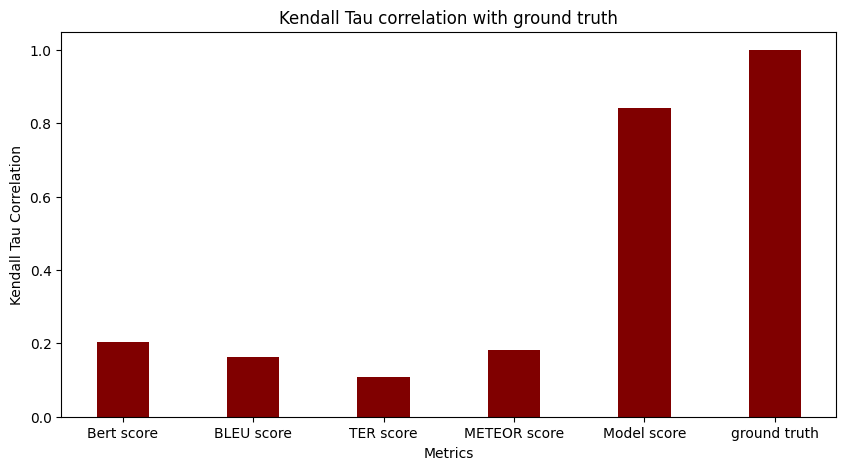

In [58]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = dic
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon',
		width = 0.4)

plt.xlabel("Metrics")
plt.ylabel("Kendall Tau Correlation")
plt.title("Kendall Tau correlation with ground truth")
plt.show()


In [ ]:
plt.plot()

In [ ]:
y_test

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])

In [ ]:
loss, accuracy = model.evaluate(x_train, y_train)


213/213 [==============================] - 2s 10ms/step - loss: 0.0300 - accuracy: 0.8734
